In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# Run this cell to connect to your Drive folder
from google.colab import drive
drive.mount('/content/gdrive')
# !conda install -y gdown

Mounted at /content/gdrive


In [ ]:
data = np.load('/content/gdrive/MyDrive/GP_dataset/cropped_data_small.npy')
mask = np.load('/content/gdrive/MyDrive/GP_dataset/cropped_masks_small.npy')

In [ ]:
print(data.shape)   # (5500, 256, 256, 1)   5500 = (11550/210) * 100pat
print(mask.shape)  # (5500, 256, 256, 1)

(11550, 160, 192, 1)
(11550, 160, 192, 1)


In [ ]:
# divide data into train & validation & test: 60, 20, 20
from sklearn.model_selection import train_test_split

# First split the data in training and remaining dataset
x_train , x_rem, y_train, y_rem = train_test_split(data,mask, train_size = 0.6, random_state= 42)

# Split to validation and test, validation size = 0.08
x_valid, x_test, y_valid, y_test = train_test_split(x_rem,y_rem, test_size=0.08, random_state= 42)

In [ ]:
import gc
del data
del mask
del x_rem, y_rem
gc.collect()

0

In [ ]:
# create tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

In [ ]:
#callbacks
checkpoint_filepath = '/checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_dice_metric',
    mode='max',
    save_best_only=True,
    verbose= 1)

In [ ]:
# !pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 KB 6.5 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras import backend as K
import keras_tuner as Kt

K.set_image_data_format('channels_last')

project_name = '2D-Dense-Unet'
img_rows = 160
img_cols = 192
img_depth = 1
# 224, 192, 160
 
def dice_metric(y_true, y_pred):
  intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis= -1))
  union = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis= -1))
  return 2*intersection / union

def jaccard_coeff(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

# class MyHyperModel(Kt.HyperModel):
def build():
    # dropout = hp.Float('dropout', 0.3, 0.8, step= 0.1)
    # lr_hp = hp.Float('lr_hp', 0.0008, 0.01, step= 0.0002)
    dropout = 0.5

    inputs = Input((img_rows, img_cols, 1))
    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conc11 = concatenate([inputs, conv11], axis=3)
    conc11 = BatchNormalization()(conc11)
    conv12 = Conv2D(32, (3, 3), activation='relu', padding='same')(conc11)
    conc12 = concatenate([inputs, conv12], axis=3)
    conc12 = BatchNormalization()(conc12)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conc12)
    pool1 = BatchNormalization()(pool1)
    # add dropout
    pool1 = Dropout(rate= dropout)(pool1)

    conv21 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conc21 = concatenate([pool1, conv21], axis=3)
    conc21 = BatchNormalization()(conc21)
    conv22 = Conv2D(64, (3, 3), activation='relu', padding='same')(conc21)
    conc22 = concatenate([pool1, conv22], axis=3)
    conc22 = BatchNormalization()(conc22)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conc22)
    pool2 = BatchNormalization()(pool2)
    pool2 = Dropout(rate= dropout)(pool2)

    conv31 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conc31 = concatenate([pool2, conv31], axis=3)
    conc31 = BatchNormalization()(conc31)
    conv32 = Conv2D(128, (3, 3), activation='relu', padding='same')(conc31)
    conc32 = concatenate([pool2, conv32], axis=3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conc32)
    pool3 = BatchNormalization()(pool3)
    pool3 = Dropout(rate= dropout)(pool3)

    conv41 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conc41 = concatenate([pool3, conv41], axis=3)
    conc41 = BatchNormalization()(conc41)
    conv42 = Conv2D(256, (3, 3), activation='relu', padding='same')(conc41)
    conc42 = concatenate([pool3, conv42], axis=3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conc42)
    pool4 = BatchNormalization()(pool4)
    pool4 = Dropout(rate= dropout)(pool4)

    conv51 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conc51 = concatenate([pool4, conv51], axis=3)
    conc51 = BatchNormalization()(conc51)
    conv52 = Conv2D(512, (3, 3), activation='relu', padding='same')(conc51)
    conc52 = concatenate([pool4, conv52], axis=3)
    conc52 = BatchNormalization()(conc52)
    conc52 = Dropout(rate= dropout)(conc52)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conc52), conc42], axis=3)
    conv61 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conc61 = concatenate([up6, conv61], axis=3)
    conc61 = BatchNormalization()(conc61)
    conv62 = Conv2D(256, (3, 3), activation='relu', padding='same')(conc61)
    conc62 = concatenate([up6, conv62], axis=3)
    conc62 = BatchNormalization()(conc62)
    # add dropout
    conc62 = Dropout(rate= dropout)(conc62)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conc62), conv32], axis=3)
    conv71 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conc71 = concatenate([up7, conv71], axis=3)
    conc71 = BatchNormalization()(conc71)
    conv72 = Conv2D(128, (3, 3), activation='relu', padding='same')(conc71)
    conc72 = concatenate([up7, conv72], axis=3)
    conc72 = BatchNormalization()(conc72)
    conc72 = Dropout(rate= dropout)(conc72)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conc72), conv22], axis=3)
    conv81 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conc81 = concatenate([up8, conv81], axis=3)
    conc81 = BatchNormalization()(conc81)
    conv82 = Conv2D(64, (3, 3), activation='relu', padding='same')(conc81)
    conc82 = concatenate([up8, conv82], axis=3)
    conc82 = BatchNormalization()(conc82)
    conc82 = Dropout(rate= dropout)(conc82)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conc82), conv12], axis=3)
    conv91 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conc91 = concatenate([up9, conv91], axis=3)
    conc91 = BatchNormalization()(conc91)
    conv92 = Conv2D(32, (3, 3), activation='relu', padding='same')(conc91)
    conc92 = concatenate([up9, conv92], axis=3)
    conc92 = BatchNormalization()(conc92)


    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conc92)

    model = tf.keras.Model(inputs=[inputs], outputs=[conv10])   

  
    model.compile(optimizer=Adam(learning_rate= 0.001), loss='binary_crossentropy', metrics=['accuracy', dice_metric, jaccard_coeff])
    
    return model

# def fit(self, hp, model, *args, **kwargs):
#     return model.fit(
#         *args,
#         # batch_size=hp.Choice("batch_size", [16, 32, 64]),
#         batch_size = 16,
#         use_multiprocessing = True,
#         **kwargs,
#     )

In [ ]:
# tuner = Kt.Hyperband(
#     hypermodel=MyHyperModel(),
#     objective= Kt.Objective("val_dice_metric", direction="max"),
#     max_epochs= 13,
#     directory="results",
#     project_name="bn & dropout tuning",
# )

In [ ]:
model = build()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 192, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 160, 192, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 concatenate_22 (Concatenate)   (None, 160, 192, 33  0           ['input_2[0][0]',                
                                )                                 'conv2d_19[0][0]']        

In [ ]:
# train model
EPOCHS = 20       # 60 + 20
BUFFER_SIZE = 500
BATCH_SIZE = 16

# train_dataset.batch(BATCH_SIZE)
# processed_train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# processed_train_dataset = processed_train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# print(train_dataset.element_spec)
# model_history = model.fit(processed_train_dataset,validation_data= (x_valid, y_valid), epochs=EPOCHS, callbacks=[checkpoint_callback])
cont_history = model.fit(processed_train_dataset,validation_data= (x_valid, y_valid), epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
434/434 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.9964 - dice_metric: 0.9105 - jaccard_coeff: 0.8357
Epoch 1: val_dice_metric did not improve from 0.88795
434/434 [==============================] - 211s 487ms/step - loss: 0.0082 - accuracy: 0.9964 - dice_metric: 0.9105 - jaccard_coeff: 0.8357 - val_loss: 0.0147 - val_accuracy: 0.9946 - val_dice_metric: 0.8847 - val_jaccard_coeff: 0.7933
Epoch 2/20
434/434 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.9964 - dice_metric: 0.9114 - jaccard_coeff: 0.8373
Epoch 2: val_dice_metric improved from 0.88795 to 0.88867, saving model to /checkpoint
434/434 [==============================] - 213s 492ms/step - loss: 0.0081 - accuracy: 0.9964 - dice_metric: 0.9114 - jaccard_coeff: 0.8373 - val_loss: 0.0150 - val_accuracy: 0.9946 - val_dice_metric: 0.8887 - val_jaccard_coeff: 0.7997
Epoch 3/20
434/434 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.9965 - dice_me

In [ ]:
# tuner.search(x_train, y_train, validation_data= (x_valid, y_valid), epochs= EPOCHS)       

In [ ]:
# tuner.results_summary()

In [ ]:
import gc
del x_train   
del y_train
gc.collect()

In [ ]:
# del processed_train_dataset 
# gc.collect()

In [ ]:
# The model weights (that are considered the best) are loaded into the model
# best_model = get_unet()      
# best_model.load_weights(checkpoint_filepath) 

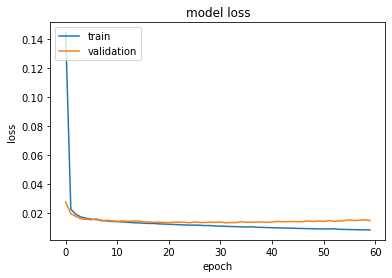

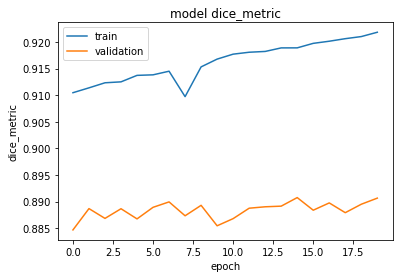

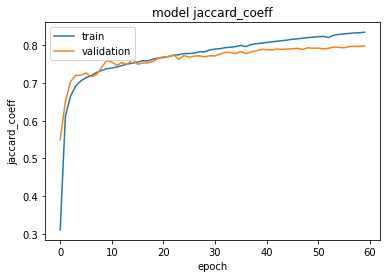

In [ ]:
# list all data in history
# print(history.history.keys())     
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for dice metric
# plt.plot(model_history.history['dice_metric'])
# plt.plot(model_history.history['val_dice_metric'])
# plt.title('model dice_metric')
# plt.ylabel('dice_metric')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()
# summarize history for dice metric
plt.plot(cont_history.history['dice_metric'])
plt.plot(cont_history.history['val_dice_metric'])
plt.title('model dice_metric')
plt.ylabel('dice_metric')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for jaccard coeff
plt.plot(model_history.history['jaccard_coeff'])     
plt.plot(model_history.history['val_jaccard_coeff'])
plt.title('model jaccard_coeff')
plt.ylabel('jaccard_coeff')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Compute and display the loss and accuracy of the trained model on the test set.
eval = model.evaluate(x_test, y_test)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}, dice metric = {}, jaccard coef = {}".format(eval[0], eval[1], eval[2], eval[3]))

12/12 [==============================] - 2s 144ms/step - loss: 0.0158 - accuracy: 0.9947 - dice_metric: 0.8919 - jaccard_coeff: 0.8050
Evaluation result on Test Data : Loss = 0.01577722653746605, accuracy = 0.9946532845497131, dice metric = 0.8919011950492859, jaccard coef = 0.8049563765525818


In [ ]:
test_predictions = model.predict(x_test, batch_size=1, verbose=1)

In [ ]:
flat = test_predictions.flatten()
np.mean(flat)  # 0.027831236
np.std(flat)  # 0.15414093

In [ ]:
binarized = (test_predictions > np.mean(flat) + np.std(flat)).astype(np.int32)

Text(0.5, 1.0, 'binary thresholded mask')

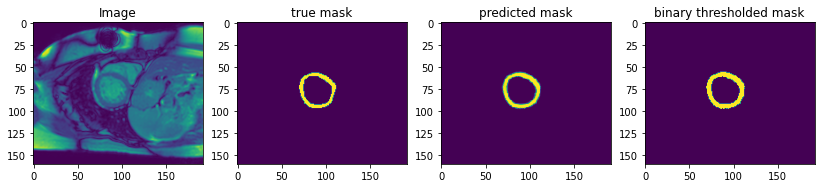

In [ ]:
# show masks and image
N = 0

fig, arr = plt.subplots(1, 4, figsize=(14, 10))
arr[0].imshow(x_test[N][:,:,0])
arr[0].set_title('Image')
arr[1].imshow(y_test[N][:,:,0])
arr[1].set_title('true mask')
arr[2].imshow(test_predictions[N][:,:,0])
arr[2].set_title('predicted mask')
arr[3].imshow(binarized[N][:,:,0])
arr[3].set_title('binary thresholded mask')

In [ ]:
# performance analysis
# Dice coefficient, jaccard coefficient: best, worst, mean, std
import statistics
import pandas as pd

metrics_results = np.zeros((2,4))
N = 370
dice_values = np.asarray([dice_metric(y_test[i], binarized[i]) for i in range(0, N)], dtype=np.float64)
jaccard_values = np.asarray([jaccard_coeff(tf.cast(y_test[i], tf.float32), tf.cast(binarized[i], tf.float32)) for i in range(0, N)], dtype=np.float64)

metrics_results[0][0] = np.amax(dice_values)
metrics_results[0][1] = np.amin(dice_values)
metrics_results[0][2] = statistics.mean(dice_values)
metrics_results[0][3] = statistics.stdev(dice_values)

metrics_results[1][0] = np.amax(jaccard_values)
metrics_results[1][1] = np.amin(jaccard_values)
metrics_results[1][2] = statistics.mean(jaccard_values)
metrics_results[1][3] = statistics.stdev(jaccard_values)

statistic = ['max', 'min', 'mean', 'std']

metric = ['dice metric', 'jaccard coefficient']

df = pd.DataFrame(metrics_results, index=metric, columns=statistic)
print(df)

                          max       min      mean       std
dice metric          0.947547  0.466484  0.867745  0.049899
jaccard coefficient  0.900428  0.304441  0.769807  0.072572


In [ ]:
worst_idx = np.where(dice_values <= 0.472231)[0][0]
best_idx = np.where(dice_values <= 0.958948)[0][0]

Text(0.5, 1.0, 'binary thresholded mask')

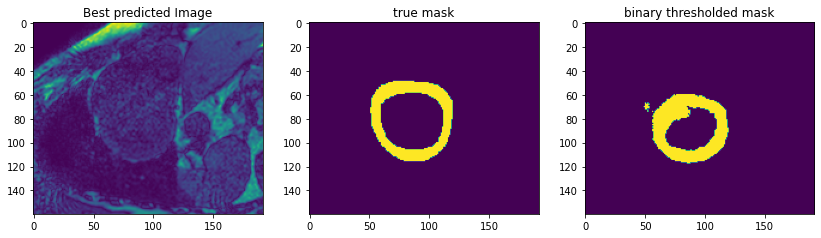

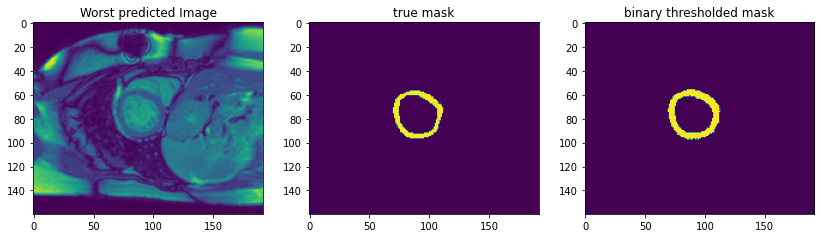

In [ ]:
fig, arr = plt.subplots(1, 3, figsize=(14, 10))
arr[0].imshow(x_test[worst_idx][:,:,0])
arr[0].set_title('Best predicted Image')
arr[1].imshow(y_test[worst_idx][:,:,0])
arr[1].set_title('true mask')
arr[2].imshow(binarized[worst_idx][:,:,0])
arr[2].set_title('binary thresholded mask')

fig, arr = plt.subplots(1, 3, figsize=(14, 10))
arr[0].imshow(x_test[best_idx][:,:,0])
arr[0].set_title('Worst predicted Image')
arr[1].imshow(y_test[best_idx][:,:,0])
arr[1].set_title('true mask')
arr[2].imshow(binarized[best_idx][:,:,0])
arr[2].set_title('binary thresholded mask')

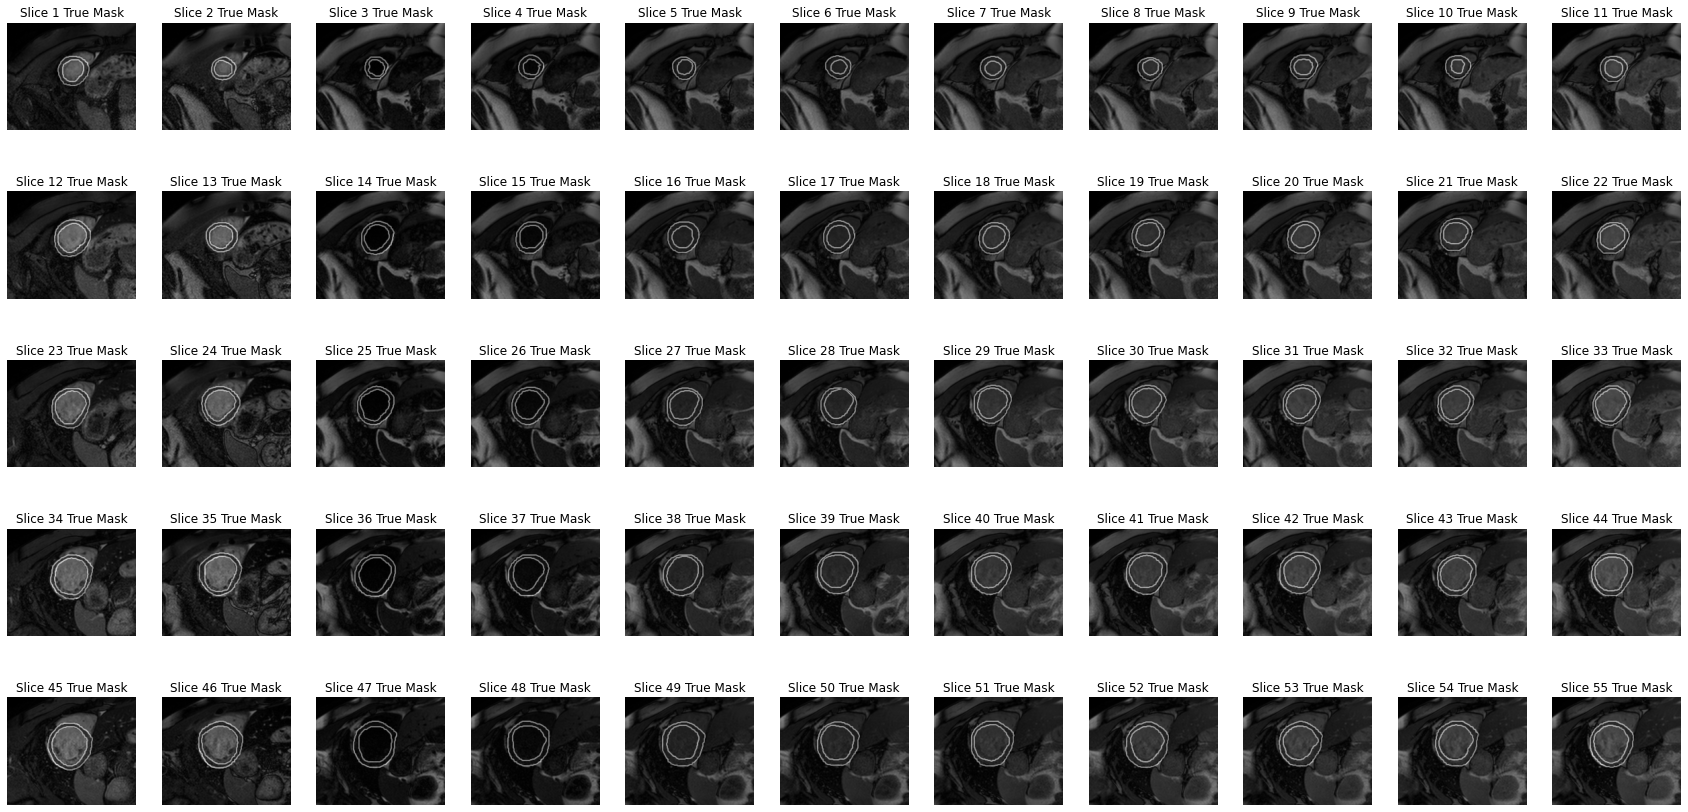

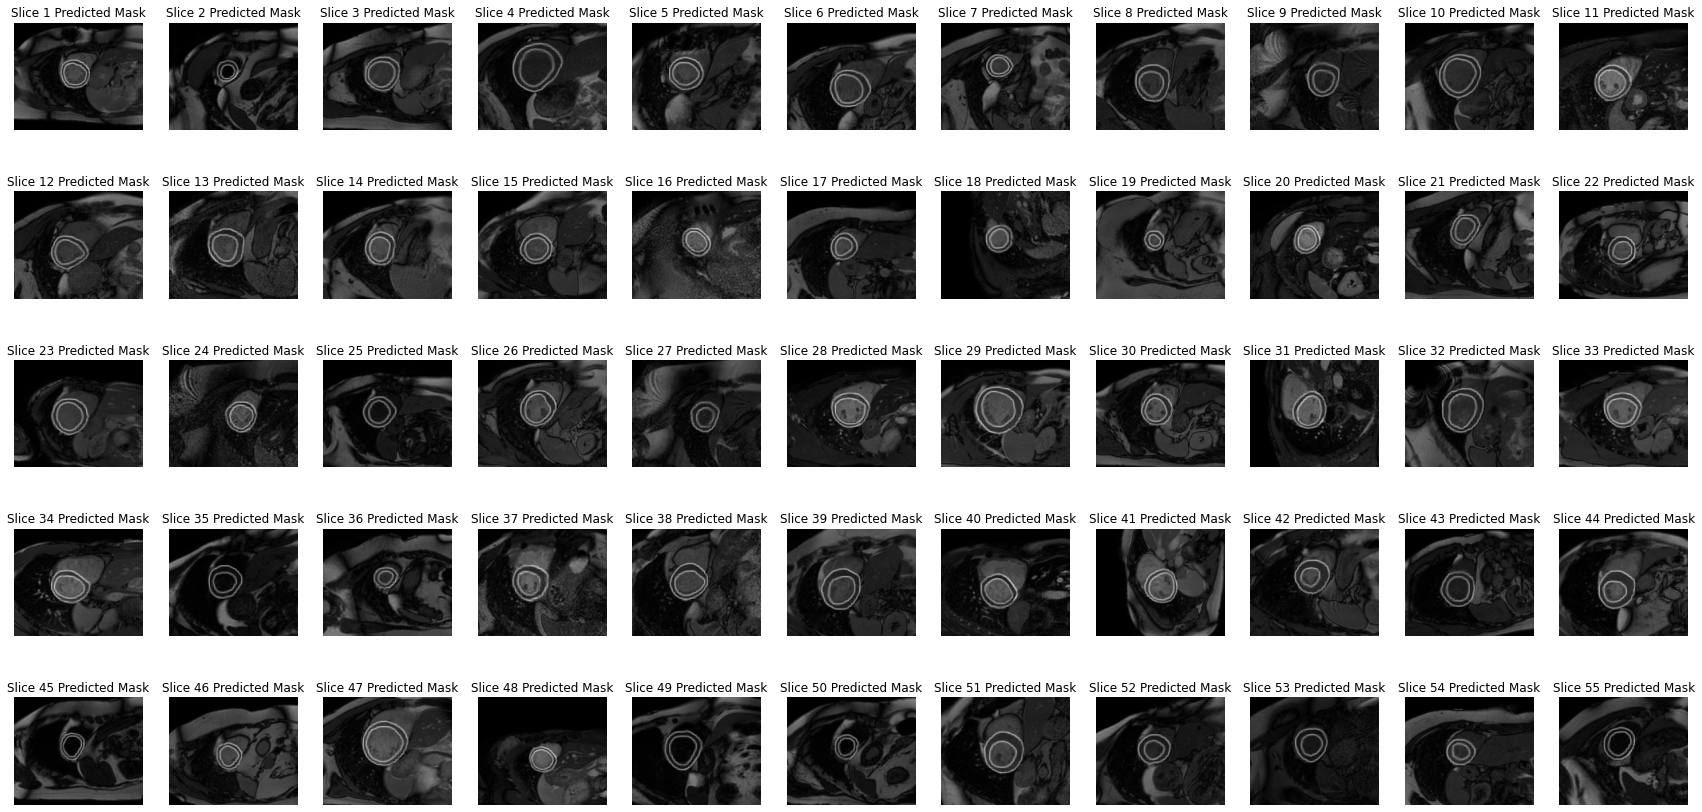

In [ ]:
# mask to poly
from scipy import ndimage

def MaskToContour(mask):
    edge_horizont = ndimage.sobel(mask, 0)
    edge_vertical = ndimage.sobel(mask, 1)
    magnitude = np.hypot(edge_horizont, edge_vertical)
    return magnitude

rows = 5
cols = 11

## Plot True Masks (first patient)
fig, axs = plt.subplots(rows,cols, figsize=(30, 15))
i,j= 0,0
for idx,(img,mask) in enumerate(zip(data[0:55],mask[0:55])):
    axs[i][j].imshow(np.squeeze(img), cmap='gray')
    axs[i][j].imshow(MaskToContour(mask[:,:,0]), cmap='gray' ,alpha=0.5)
    axs[i][j].axis('off')
    axs[i][j].set_title(f'Slice {idx+1} True Mask')
                 
    j+=1
    if j%cols==0:
        i+=1
        j=0
plt.show()
print()

## Plot Predicted Masks (first patient)
fig, axs = plt.subplots(rows,cols, figsize=(30, 15))
i,j=0,0
for idx, img in enumerate(x_test[0:55]):
    axs[i][j].imshow(np.squeeze(img), cmap='gray')
    predicted = model.predict(np.expand_dims(img, axis=0), verbose=0)[0]
    axs[i][j].imshow(MaskToContour(predicted[:,:,0]), cmap='gray' ,alpha=0.5)
    axs[i][j].axis('off')
    axs[i][j].set_title(f'Slice {idx+1} Predicted Mask')

    j+=1
    if j%cols==0:
        i+=1
        j=0
plt.show()

In [ ]:
mask.shape
# len(mask)

(11550, 160, 192, 1)

In [ ]:
del train_dataset
del x_test, y_test 
gc.collect()

122

In [ ]:
## Evaluating inversions
i1,i2,i3,i4,i5,i6,i7,i8,i9,i10,i11 = [],[],[],[],[],[],[],[],[],[],[]

i = 0
while  i < 5775 - 11:
       i1.append([data[i],mask[i]])
       i2.append([data[i+1],mask[i+1]])
       i3.append([data[i+2],mask[i+2]]) 
       i4.append([data[i+3],mask[i+3]])
       i5.append([data[i+4],mask[i+4]])
       i6.append([data[i+5],mask[i+5]])
       i7.append([data[i+6],mask[i+6]])
       i8.append([data[i+7],mask[i+7]])
       i9.append([data[i+8],mask[i+8]])
       i10.append([data[i+9],mask[i+9]])
       i11.append([data[i+10],mask[i+10]])

       i= i + 11 

i1 = np.array(i1)
i2 = np.array(i2)
i3 = np.array(i3)
i4 = np.array(i4)
i5 = np.array(i5)
i6 = np.array(i6)
i7 = np.array(i7)
i8 = np.array(i8)
i9 = np.array(i9)
i10 = np.array(i10)
i11 = np.array(i11)
print(i1.shape)
#####################
model.compile(optimizer='adam', loss='binary_crossentropy' , metrics=[jaccard_coeff,dice_metric])
dices = []
inversions = []
for idx, i in enumerate([i1,i2,i3,i4,i5,i6,i7,i8,i9,i10,i11]):
    dice = model.evaluate(i[:,0,:,:], i[:,1,:,:])[2]
    del i
    dices.append(dice)
    inversions.append(idx+1)

#############################
plt.title('Dice metric for each inversion')
plt.ylabel('Dice')
plt.xlabel('Inversion')
plt.plot(inversions,dices)

In [ ]:
## Evaluating inversions
i1,i2,i3,i4,i5,i6,i7,i8,i9,i10,i11 = [],[],[],[],[],[],[],[],[],[],[]

i = 0
while  i <len(x_train):
       i1.append([x_train[i],y_train[i]])
       i2.append([x_train[i+1],y_train[i+1]])
       i3.append([x_train[i+2],y_train[i+2]]) 
       i4.append([x_train[i+3],y_train[i+3]])
       i5.append([x_train[i+4],y_train[i+4]])
       i6.append([x_train[i+5],y_train[i+5]])
       i7.append([x_train[i+6],y_train[i+6]])
       i8.append([x_train[i+7],y_train[i+7]])
       i9.append([x_train[i+8],y_train[i+8]])
       i10.append([x_train[i+9],y_train[i+9]])
       i11.append([x_train[i+10],y_train[i+10]])

       i= i + 11 

i1 = np.array(i1)
i2 = np.array(i2)
i3 = np.array(i3)
i4 = np.array(i4)
i5 = np.array(i5)
i6 = np.array(i6)
i7 = np.array(i7)
i8 = np.array(i8)
i9 = np.array(i9)
i10 = np.array(i10)
i11 = np.array(i11)
print(i1.shape)
#####################
model.compile(optimizer='adam', loss='binary_crossentropy' , metrics=[jaccard_coeff,dice_metric])
dices = []
inversions = []
for idx, i in enumerate([i1,i2,i3,i4,i5,i6,i7,i8,i9,i10,i11]):
    dice = model.evaluate(i[:,0,:,:], i[:,1,:,:])[2]
    del i
    dices.append(dice)
    inversions.append(idx+1)

dices
#############################
plt.title('Dice metric for each inversion')
plt.ylabel('Dice')
plt.xlabel('Inversion')
plt.plot(inversions,dices)